<h2 style='color: orange'>Équipe: Louis & Emire</h2>

### 5. Comparaison des performances entre les méthodes linéaires vs méthodes non-linéaires pour la prédiction sur de vraies données transcriptomiques des cancers de TCGA.

# Workplan

1. Review litterature about the type of ML algorithms and their models
2. Data importation: `TCGA dataset`
3. Data preprocessing -> experience data
4. Algorithms/models configuration
5. Models training
6. Comparison with figures
   - 2 clusters containing maximum 4 figures each.
   - 1 classification plot for each algorithm (2 in total for each cluster)

In [99]:
# Librairies
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import itertools
from collections import Counter
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from utils.random_color_generator import random_color_generator
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix

In [100]:
from utils.DataSet import DataSet

# Data importation and pre-processing

data_set = DataSet('./data/TCGA_TPM_hv_subset.h5')

figures_directory = "./figures/project"

data = data_set.get_data('data', float)

genes = data_set.get_data('cols', str)
labels = data_set.get_data('labels', str)
rows = data_set.get_data('rows', str)

### A. Pour la classification moléculaires entre la régression linéaire et un DNN, quelle méthode fonctionne le mieux et pourquoi?


#### Régression Logistique

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(data.T, labels, test_size= 0.2)
log_clf = RidgeClassifier(alpha=1e-4, solver ="lsqr", max_iter = 100)
log_clf.fit(X_train, Y_train)
predict = log_clf.predict(X_test) == Y_test

print(f"Accuracy on train set (n = {X_train.shape[0]}): {round((np.mean(log_clf.predict(X_train) == Y_train)), 2) * 100}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {round((np.mean(log_clf.predict(X_test) == Y_test)), 2) * 100}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")

Accuracy on train set (n = 8276): 100.0%
Accuracy on test set (n = 2070): 97.0%
Number of errors : 72


Analysis

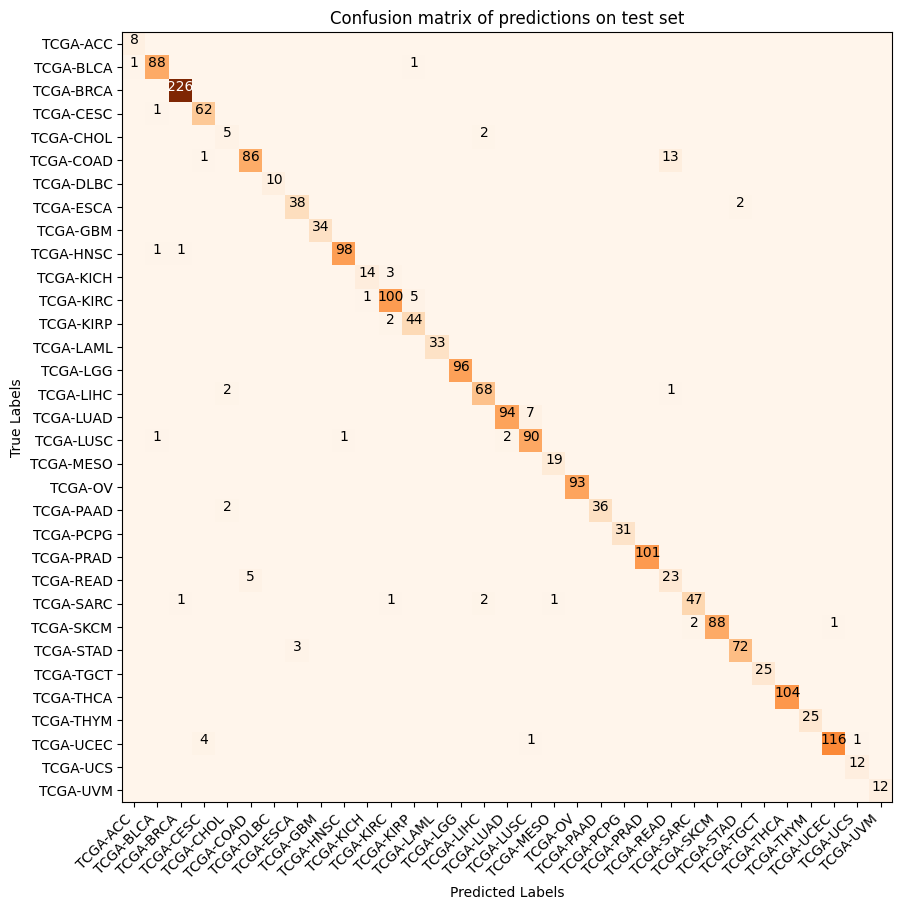

In [101]:
cm = confusion_matrix(log_clf.predict(X_test),  Y_test)

ax = plt.figure(figsize = (10, 10))
plt.imshow(cm, cmap='Oranges', vmin=cm.min(), vmax=cm.max())
plt.xticks(np.arange(len(np.unique(labels))), labels = np.unique(labels), rotation = 45, ha='right')
plt.yticks(np.arange(len(np.unique(labels))), labels = np.unique(labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion matrix of predictions on test set")

thresh = cm.max() / 1.5

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        plt.text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

plt.savefig(f"{figures_directory}/linear_regression_confusion_matrix_test.svg", format="svg")

#### DNN

Data

In [ ]:
lblbin = LabelBinarizer()

targets = lblbin.fit_transform(labels)

X, Y = torch.Tensor(data.T), torch.Tensor(targets)

X_train, X_test, Y_train, Y_test = [torch.Tensor(split) for split in train_test_split(data.T, targets, test_size = 0.2)]

Model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, insize, outsize):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(insize, 100), # couche entrée
            nn.Linear(100, 100), # couche cahée
            nn.Linear(100, outsize)  # couche sortie
        )

    def train(self, nepochs = 1000, printstep = 100):
        mm = self.linear_relu_stack        
        optimizer = torch.optim.Adam(mm.parameters(), lr = 1e-4)
        tr_losses, tst_losses, tr_accs, tst_accs = [], [], [], [] 
        # boucle de training 
        for i in range(nepochs):
            #####
            optimizer.zero_grad() # required*
            out_tr = mm(X_train) # calcul 'avant'
            tr_error = nn.functional.cross_entropy(out_tr, Y_train)
            out_test = mm(X_test)
            tst_error = nn.functional.cross_entropy(out_test, Y_test)
            tr_acc = np.mean(np.array( out_tr.max(1).indices == Y_train.max(1).indices))
            tst_acc = np.mean(np.array( out_test.max(1).indices == Y_test.max(1).indices))
            [tr_losses.append(float(tr_error)),tst_losses.append(float(tst_error)),
            tr_accs.append(tr_acc), tst_accs.append(tst_acc) ]
            tr_error.backward() # calcul 'arriere' et mise a jour
            optimizer.step() # required*
            if i % printstep == 0 or i == nepochs - 1:
                print(f"{i} Loss Train : {round(float(tr_error) * 100,2)} - Acc: {round(tr_acc * 100,2)} \
                    - Test : {round(float(tst_error) * 100,2)} - Acc: {round(tst_acc * 100,2)} \
                        - errors: {np.sum(np.array( out_test.max(1).indices != Y_test.max(1).indices))}")
        return mm, tr_losses, tst_losses, np.array(tr_accs), np.array(tst_accs)

    

Training

In [ ]:
nni = NeuralNetwork(X_train.shape[1], Y_train.shape[1])
mm, tr_losses, tst_losses, tr_accs, tst_accs = nni.train(nepochs = 1000, printstep = 100)

Analysis

In [ ]:
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])

steps = np.arange(len(tr_losses))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
axes[0].plot(steps, tr_losses, label = "train", color='green')
axes[0].plot(steps, tst_losses, label= "test", color='blue')
axes[1].plot(steps, tr_accs * 100, label = "train", color='green')
axes[1].plot(steps, tst_accs * 100, label= "test", color='blue')
# Adding markers for the last value in each dataset
axes[0].plot(steps[-1], tr_losses[-1], 'go', markersize=5,  label=f'({steps[-1]}, {tr_losses[-1]:.2f})')  # Last test loss
axes[0].plot(steps[-1], tst_losses[-1], 'bv', markersize=5, label=f'({steps[-1]}, {tst_losses[-1]:.2f})')  # Last test loss
axes[1].plot(steps[-1], tr_accs[-1] * 100, 'go',  markersize=5, label=f'({steps[-1]}, {tr_accs[-1]*100:.2f}%)')  # Last training accuracy
axes[1].plot(steps[-1], tst_accs[-1] * 100, 'bv',  markersize=5, label=f'({steps[-1]}, {tst_accs[-1]*100:.2f}%)')  # Last test accuracy
axes[0].set_ylabel("Cross entropy loss")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_ylim((0,100))
axes[1].set_xlabel("Epochs number")
axes[0].legend()
axes[1].legend()
axes[0].set_title(f"Learning curves of DNN on classification of cancer type in TCGA data\nN={data.T.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")

#### B. Pour la régression entre la régression linéaire et un Auto-Encodeur, quelle méthode fonctionne le mieux et pourquoi?


#### C. Démontrez qu'une PCA 2D est équivalent à la couche interne bottleneck d'Auto-Encodeur linéaire.